# Home Exercise on Linear Regression
# Task Description
Implement a **linear regression model** using **gradient descent, Adam, any other optimization method** to optimize the parameters or closed-form solution. (You can use other variations of Linear Regression, such as **Lasso, Ridge, etc,** but you must implement them yourself.)


You are only allowed to use **computational libraries** such as NumPy, Math, etc for implementing **the model and training process.**
You **must not** use machine learning libraries or frameworks like **scikit-learn, TensorFlow, PyTorch, etc.** that provide pre-built models.
For other tasks (e.g., data processing, visualization), you are free to use any library.
After implementing the model, use it to solve the following problem: Housing Prices Competition for Kaggle Learn Users

# Data loading and import library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

+ If you run on kaggle add input the houseprice dataset and run, else use the 4 line other comment below

In [2]:
# train = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv", index_col = "Id")
# test  = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv", index_col = "Id")

!gdown 13Jcpv1b7EI9xsmsZqvEuzNc7pI_fGtrh -O home-data-for-ml-course.zip
!unzip home-data-for-ml-course.zip
train = pd.read_csv("train.csv", index_col = "Id")
test  = pd.read_csv("test.csv", index_col = "Id")

Downloading...
From: https://drive.google.com/uc?id=13Jcpv1b7EI9xsmsZqvEuzNc7pI_fGtrh
To: /content/home-data-for-ml-course.zip
100% 395k/395k [00:00<00:00, 34.8MB/s]
Archive:  home-data-for-ml-course.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.gz  
  inflating: test.csv                
  inflating: test.csv.gz             
  inflating: train.csv               
  inflating: train.csv.gz            


+ **Define some function**

In [3]:
from sklearn import preprocessing as preprocessing
from sklearn.metrics import mean_absolute_error
import types

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

def save(index, preds):
    # Save test predictions to file
    output = pd.DataFrame({'Id': index,
                           'SalePrice': preds})
    output.to_csv('submission.csv', index=False)

def fill_garageyrblt(data, c):
    rows = data['GarageYrBlt'].isnull()
    data.loc[rows, 'GarageYrBlt']= \
    data.loc[rows, 'YearBuilt']

def miss_val_handler(data):

    def _handle_(data, c, v):
        if isinstance(v, types.FunctionType):
            v(data, c)
        else:
            null_r = data[c].isnull()
            if null_r.sum() == 0: return
            data.loc[null_r, c] = v

    for c in MISS_VAL:
        v = MISS_VAL[c]
        if isinstance(v, tuple):
            for e in v:
                _handle_(data, c, e)
        else:
            _handle_(data, c, v)

def BsmtExposure_no(data,c):
    #data.loc[949, 'BsmtExposure']='No'
    pass

def median_impute(data, c):
    null_r = data[c].isnull()
    if null_r.sum() == 0: return
    data.loc[null_r, c] = data[c].median()

def most_freq_impute(data, c):
    null_r = data[c].isnull()
    if null_r.sum() == 0: return
    data.loc[null_r, c] = data[c].mode()[0]

# Preprocessing data

In [4]:
## Chosen numeric features
N_FEATS = ['BedroomAbvGr', 'GrLivArea', 'LowQualFinSF', 'YearBuilt', 'FullBath',
           'EnclosedPorch', '1stFlrSF', 'BsmtFinSF2', 'OverallQual', 'YearRemodAdd',
           'BsmtUnfSF', 'LotArea', 'KitchenAbvGr', 'Fireplaces', 'OverallCond',
           'TotRmsAbvGrd', 'PoolArea', 'LotFrontage', 'OpenPorchSF', 'BsmtFinSF1',
           'GarageYrBlt', 'TotalBsmtSF', 'GarageCars', '3SsnPorch', 'BsmtHalfBath',
           'WoodDeckSF', '2ndFlrSF', 'GarageArea', 'BsmtFullBath', 'MiscVal', 'ScreenPorch',
           'HalfBath', 'MasVnrArea', 'YrSold']

## Chosen categrical featrues
C_FEATS = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
           'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType','HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
           'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
           'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
           'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
           'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
           'SaleCondition', 'MoSold', 'MSSubClass']

## Doc of Values for missing value to fill.
## where key is column name and value to fill missing value
MISS_VAL = {'PoolQC': 'NA',
            'FireplaceQu': 'NA',
            'GarageCond': 'NA',
            'GarageType': 'NA',
            'GarageFinish': 'NA',
            'GarageQual': 'NA',
            'BsmtExposure': ('NA', BsmtExposure_no),
            'BsmtFinType2': 'NA',
            'BsmtFinType1': 'NA',
            'BsmtQual': 'NA',
            'BsmtCond': 'NA',
            'MasVnrType': 'None',
            'Electrical': 'SBrkr',
            'MasVnrArea': 0,
            'LotFrontage': median_impute,
            'GarageYrBlt': fill_garageyrblt,
            'BsmtFullBath':0,
            'BsmtHalfBath':0,
            'TotalBsmtSF': 0,
            'BsmtFinSF1': 0,
            'BsmtUnfSF': 0,
            'BsmtFinSF2': 0,
            'Exterior1st': most_freq_impute,
            'Exterior2nd': most_freq_impute,
            'MSZoning': most_freq_impute,
            'Functional': most_freq_impute,
            'Utilities': most_freq_impute,
            'KitchenQual': most_freq_impute,
            'SaleType': most_freq_impute,
            'GarageArea': 0,
            'GarageCars': 0}

## Ordinal features
ORDINAL = ['ExterQual','BsmtQual', 'KitchenQual',
           'GarageQual', 'HeatingQC', 'PoolQC',
           'GarageType', 'GarageFinish', 'GarageCond',
           'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
           'BsmtFinType2', 'FireplaceQu', 'Electrical',
           'LotShape', 'Functional', 'ExterCond',
           'Utilities', 'PavedDrive']

## Features to be one-hot encoded
ONE_HOT = ['LandSlope', 'LotConfig', 'Foundation', 'MSSubClass', 'SaleType', 'MSZoning',
           'Neighborhood', 'MoSold', 'Condition1', 'Exterior2nd', 'BldgType', 'RoofStyle',
           'HouseStyle', 'CentralAir', 'Heating', 'MasVnrType', 'LandContour', 'Street',
           'Exterior1st', 'Condition2', 'SaleCondition', 'RoofMatl']

QT = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
OHE = preprocessing.OneHotEncoder(dtype='int', handle_unknown='ignore')
ORDE = preprocessing.OrdinalEncoder()
CT = ColumnTransformer([('ohe', OHE, ONE_HOT),
                        ('orde', ORDE, ORDINAL),
                        ('qt', QT, N_FEATS)],
                     remainder='drop')

FEATS = N_FEATS + ORDINAL + ONE_HOT

In [5]:
MISS_VAL.update({'BsmtFullBath':0,
                 'BsmtHalfBath': 0,
                 'TotalBsmtSF': 0,
                 'BsmtFinSF1': 0,
                 'BsmtUnfSF': 0 })

MISS_VAL.update({'Exterior1st': most_freq_impute,
                 'Exterior2nd': most_freq_impute,
                 'MSZoning': most_freq_impute,
                 'Functional': most_freq_impute,
                 'Utilities': most_freq_impute,
                 'KitchenQual': most_freq_impute,
                 'SaleType': most_freq_impute})

MISS_VAL.update({'GarageArea': 0,
                 'GarageCars': 0})

## fill missing values and check

In [6]:
test_data = test[FEATS].copy()
miss_val_handler(test_data) # apply same rule of train data
test_data.isnull().sum().sort_values(ascending=False).head(1)

,0
BedroomAbvGr,0


# Preprocess train and test data

+ **At this stage I only merged the dataset to get the test_data have one more column SalePrice and then spilt out again to make sure it not fit_transform on both dataset**

In [7]:
test_data = test.copy()
train_data = train.copy()
# test + train data merge
merged = pd.concat([train_data, test_data], sort=True)

train_data = merged.iloc[:1460, :].copy()
test_data = merged.iloc[1460:, :].copy()

# #print(merged.info())

# print(train_data.info())

miss_val_handler(test_data)
miss_val_handler(train_data)


train_data_preprocessing = CT.fit_transform(train_data)
try:
    test_data_preprocessing = CT.transform(test_data)
except ValueError:
    print("Lỗi: Có giá trị mới trong test. Sử dụng median của train để thay thế.")
    test_data[ORDINAL] = test_data[ORDINAL].apply(lambda x: x.map(lambda v: v if v in ORDE.categories_[0] else None))
    test_data_preprocessing = CT.transform(test_data)

# Create Model

In [8]:
import numpy as np

class LinearRegressionCustom:
    def __init__(self, learning_rate=0.0005, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = None

    def fit(self, X, y):
        m, n = X.shape
        X = np.c_[np.ones(m), X]  # Add bias term
        self.theta = np.zeros(n + 1)

        for _ in range(self.iterations):
            predictions = X.dot(self.theta)
            errors = predictions - y
            gradient = (8.1 / m) * X.T.dot(errors)
            self.theta -= self.learning_rate * gradient
            #print(errors)

        # Ridge
    # def fit(self, X, y, lambda_=0.1):  # Thêm lambda_ để điều chỉnh regularization
    #     m, n = X.shape
    #     X = np.c_[np.ones(m), X]  # Thêm bias term
    #     self.theta = np.zeros(n + 1)

    #     for _ in range(self.iterations):
    #         predictions = X.dot(self.theta)
    #         errors = predictions - y
    #         gradient = (7 / m) * X.T.dot(errors) + lambda_ * np.r_[0, self.theta[1:]]  # Không regularize bias
    #         self.theta -= self.learning_rate * gradient

        # Lasso
    # def fit(self, X, y, lambda_=0.1):
    #     m, n = X.shape
    #     X = np.c_[np.ones(m), X]  # Thêm bias term
    #     self.theta = np.zeros(n + 1)

    #     for _ in range(self.iterations):
    #         predictions = X.dot(self.theta)
    #         errors = predictions - y
    #         gradient = (8 / m) * X.T.dot(errors) + lambda_ * np.r_[0, np.sign(self.theta[1:])]  # Không regularize bias
    #         self.theta -= self.learning_rate * gradient


    def predict(self, X):
        m = X.shape[0]
        X = np.c_[np.ones(m), X]  # Add bias term
        return X.dot(self.theta)


# Training model using train_dataset

In [9]:
# regression
#lr = LinearRegression()

lr = LinearRegressionCustom()

lr.fit(train_data_preprocessing, QT.fit_transform(train['SalePrice'].values.reshape(-1, 1)).ravel())
# print(mean_absolute_error(train['SalePrice'],QT.inverse_transform(lr.predict(train_data_preprocessing).reshape(-1,1))))

In [10]:
preds = QT.inverse_transform(lr.predict(test_data_preprocessing).reshape(-1,1)).sum(axis=1)

print(preds)

[123039.69024447 151129.58133089 186894.0918324  ... 173956.05911008
 119762.99314503 232633.25334343]


# Generate a csv file

In [11]:
save(test_data.index, pd.Series(preds))

# Image of submission

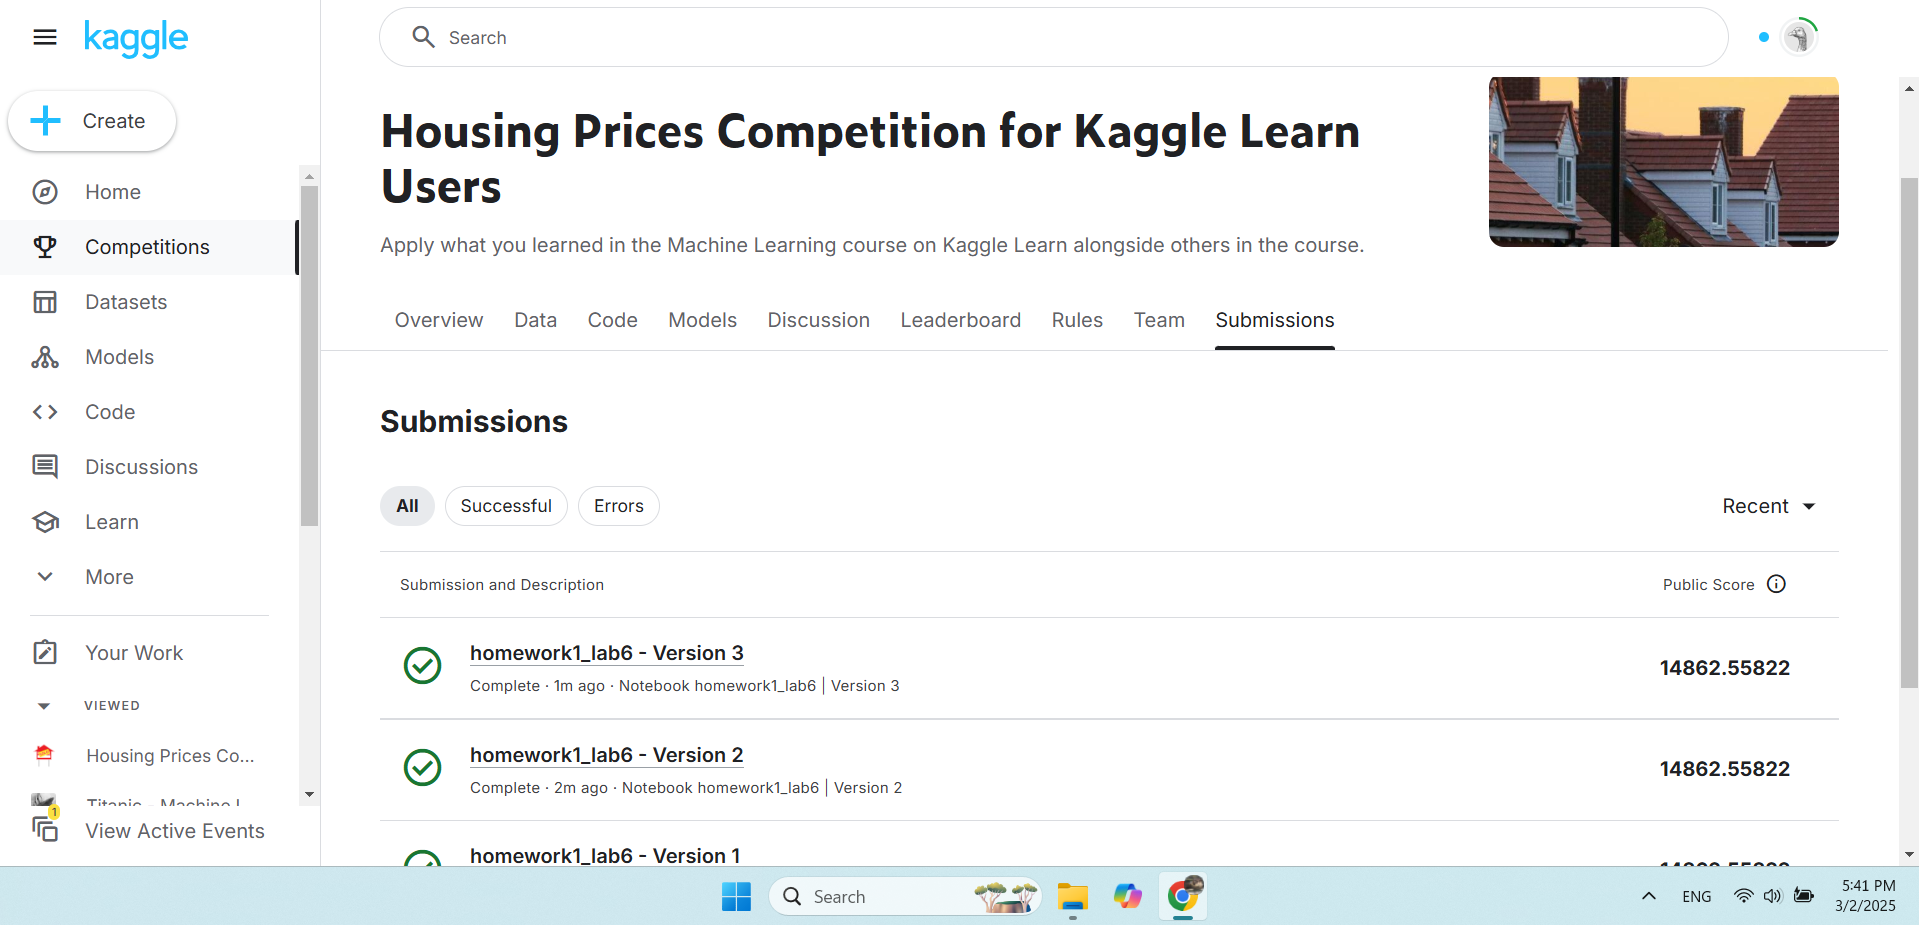